# Transfer learning and fine tuning for image classification

## Transfer learning

In [ ]:
# 전이 학습
# 첫번째 Conv2D층과 풀링층의 가중치는 고정하고(객체의 일반적인 특성과 더 연관) -> 베이스 모델
# 알고리즘의 밀집층(더 구체적인 특성을 나타냄)의 가중치만 조정.

### Importing the libraries

In [1]:
import tensorflow as tf
import seaborn as sns
import zipfile
import numpy as np
import cv2
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing.image import ImageDataGenerator # 폴더의 전체 이미지를 읽기 위함.
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
# Input -> 신경망의 입력층, GlobalAveragePooling2D -> 평탄화 층과 유사
tf.__version__

'2.17.1'

### Loading the images

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
path = '/content/drive/MyDrive/Computer Vision/Datasets/homer_bart_2.zip'
zip_object = zipfile.ZipFile(file=path, mode='r')
zip_object.extractall('./')
zip_object.close()

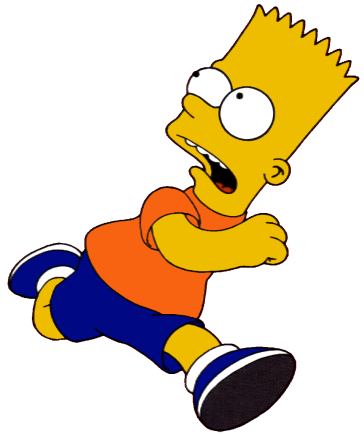

In [4]:
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/bart/bart100.bmp')

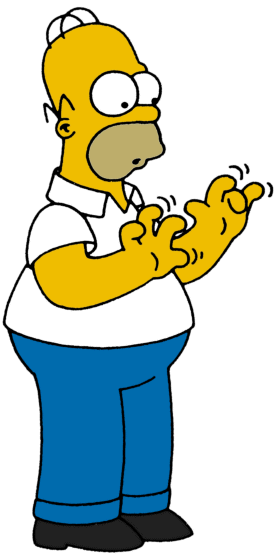

In [5]:
tf.keras.preprocessing.image.load_img('/content/homer_bart_2/training_set/homer/homer100.bmp')

### Train and test set

In [6]:
training_generator = ImageDataGenerator(rescale=1./255,
                                        rotation_range=7,
                                        horizontal_flip=True,
                                        zoom_range=0.2)

train_dataset = training_generator.flow_from_directory('/content/homer_bart_2/training_set',
                                                      target_size=(256,256),
                                                      batch_size=8,
                                                      class_mode='categorical',
                                                      shuffle=True)

Found 215 images belonging to 2 classes.


In [7]:
train_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [8]:
train_dataset.class_indices

{'bart': 0, 'homer': 1}

In [9]:
test_generator = ImageDataGenerator(rescale=1./255)
test_dataset = test_generator.flow_from_directory('/content/homer_bart_2/test_set',
                                                  target_size=(256,256),
                                                  batch_size=1,
                                                  class_mode='categorical',
                                                  shuffle=False)

Found 54 images belonging to 2 classes.


### Pre-trained network

- ResNet: https://arxiv.org/pdf/1512.03385.pdf
- Documentation: https://keras.io/api/applications/

In [12]:
# 이미 학습된, 일부가 설계된 신경망을 선택 -> 이 신경망을 다시 학습시킬 필요가 없음.
# DensNet, EfficientNet, Inception, MobileNet 은 구글이 개발한 유명한 합성곱 신경망
# ResNet50 -> 이번 강의에서 사용할 합성곱 신경망의 구조.
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,
                                            input_tensor=Input(shape=(256,256,3)))

# weights='imagenet' -> ImageNet(데이터셋 이름)으로 학습한 구조를 의미
# 텐서플로 라이브러리에서 사용 가능한 ResNet 아키텍처와 다른 모든 아키텍처는 ImageNet 데이터셋으로 이미 학습되어 있음
# 해당 데이터셋에서 사용 가능한 1000개의 객체를 분류할 수 있다는 의미.
# include_top=True -> 1000개의 전체 객체를 분류할 수 있다는 의미
# include_top=False -> 이 아키텍처의 밀집된 부분(밀집층)은 사용하지 않는다는 것을 의미.
# 전이 학습에서의 목표는 사용자 정의의 밀집 신경망이나 신경망의 사용자 정의 헤드를 설정하는 것.
# input_tensor -> 텐서플로에서 가져온 입력층. 신경망의 입력값을 의미
# input_tensor=Input(shape=(256,256,3)) -> 이 shape는 학습, 검증 data셋과 반드시 일치해야 함.
# shape는 공식 문서에서 확인 가능.

# 간단한 문제 발생 시 나만의 신경망을 생성 가능.
# 복잡한 문제 발생 시 이미 설계된 아키텍쳐 사용 추천.


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [13]:
base_model.summary()
# BatchNormalization -> 은닉층의 뉴런을 정규화하는 층
# Add -> 한 층을 다른 층에 추가
# include_top=True 로 하면 GlobalAveragePooling2D 층 추가됨. Output Shape의 2048은 신경망 밀집층의 입력층으로 보낼 픽셀 또는 뉴런의 개수
# 마지막 Dense층의 크기는 1000. ImageNet 데이터셋에 1000개의 객체가 있기 때문.
# 즉, include_top=True 로 하면 이 구조를 사용해서 ImageNet 데이터셋에 있는 전체 객체를 분류 가능.
# 만약 트럭을 분류하고자 한다면 사용자 정의 구조를 설계할 필요 없음.
# ImageNet에 해당 클래스가 있어서 이미 설계된 신경망을 객체 분류에 사용하면 되기 때문.

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
len(base_model.layers)  # 층 개수. 조정될 총 매개 변수 혹은 가중치 개수는 23,587,712

175

In [ ]:
for layer in base_model.layers:
    print(layer, layer.trainable)

<InputLayer name=input_layer_1, built=True> True
<ZeroPadding2D name=conv1_pad, built=True> True
<Conv2D name=conv1_conv, built=True> True
<BatchNormalization name=conv1_bn, built=True> True
<Activation name=conv1_relu, built=True> True
<ZeroPadding2D name=pool1_pad, built=True> True
<MaxPooling2D name=pool1_pool, built=True> True
<Conv2D name=conv2_block1_1_conv, built=True> True
<BatchNormalization name=conv2_block1_1_bn, built=True> True
<Activation name=conv2_block1_1_relu, built=True> True
<Conv2D name=conv2_block1_2_conv, built=True> True
<BatchNormalization name=conv2_block1_2_bn, built=True> True
<Activation name=conv2_block1_2_relu, built=True> True
<Conv2D name=conv2_block1_0_conv, built=True> True
<Conv2D name=conv2_block1_3_conv, built=True> True
<BatchNormalization name=conv2_block1_0_bn, built=True> True
<BatchNormalization name=conv2_block1_3_bn, built=True> True
<Add name=conv2_block1_add, built=True> True
<Activation name=conv2_block1_out, built=True> True
<Conv2D name

In [ ]:
for layer in base_model.layers:
    layer.trainable = False  # 이렇게 설정하면 이 신경망 학습 시 모든 매개변수는 고정된 채로 유지됨.

In [ ]:
for layer in base_model.layers:
    print(layer, layer.trainable)
# layer.trainabled의 결과가 True이면 각 층의 매개변수가 조정됨.
# 하지만 전이 학습의 개념은 이 가중치를 유지하는 것.

<InputLayer name=input_layer_1, built=True> False
<ZeroPadding2D name=conv1_pad, built=True> False
<Conv2D name=conv1_conv, built=True> False
<BatchNormalization name=conv1_bn, built=True> False
<Activation name=conv1_relu, built=True> False
<ZeroPadding2D name=pool1_pad, built=True> False
<MaxPooling2D name=pool1_pool, built=True> False
<Conv2D name=conv2_block1_1_conv, built=True> False
<BatchNormalization name=conv2_block1_1_bn, built=True> False
<Activation name=conv2_block1_1_relu, built=True> False
<Conv2D name=conv2_block1_2_conv, built=True> False
<BatchNormalization name=conv2_block1_2_bn, built=True> False
<Activation name=conv2_block1_2_relu, built=True> False
<Conv2D name=conv2_block1_0_conv, built=True> False
<Conv2D name=conv2_block1_3_conv, built=True> False
<BatchNormalization name=conv2_block1_0_bn, built=True> False
<BatchNormalization name=conv2_block1_3_bn, built=True> False
<Add name=conv2_block1_add, built=True> False
<Activation name=conv2_block1_out, built=True>

### Custom dense layer

In [ ]:
# 새로운 밀집층을 베이스 모델의 아키텍처 중 마지막 층에 연결해야함.
# conv5_block3_3_conv <- 이게 마지막 층임. 그 뒤의 배치 정규화, add, 활성화 층은 마지막 층에 해당 연산을 적용하기 위한 방법일 뿐..
base_model.output

<KerasTensor shape=(None, 8, 8, 2048), dtype=float32, sparse=False, name=keras_tensor_349>

In [ ]:
# 헤드 모델(새로운 밀집층) 선언
head_model = base_model.output # (8, 8, 2048) -> 이 행렬의 형태로 이루어진 각 데이터를 밀집층의 입력층으로 보내기 위해 벡터로 변환해야 함.
head_model = GlobalAveragePooling2D()(head_model) # GlobalAveragePooling2D() -> 행렬의 평균값을 이용해 벡터로 변환. 층을 서로 연결.

head_model = Dense(units=1025, activation='relu')(head_model) # 층을 서로 연결. 이런식으로 연결하는 이유는 Sequential() 대신 Model 이라는 클래스를 사용할 것이기 때문.
head_model = Dropout(rate=0.2)(head_model) # 과적합 방지

head_model = Dense(units=1025, activation='relu')(head_model)
head_model = Dropout(rate=0.2)(head_model)

head_model = Dense(2, activation='softmax')(head_model)

### Building and training the neural network

In [ ]:
# 합성곱 신경망층과 밀집층을 연결하여 하나의 객체를 생성해야 함.
base_model.input

[<KerasTensor shape=(None, 256, 256, 3), dtype=float32, sparse=False, name=keras_tensor_175>]

In [ ]:
network = Model(inputs=base_model.input, outputs=head_model) # 신경망의 입력층과 마지막층을 매개변수로 입력.
# 모든 층을 결합하는 단일 신경망을 갖게 됨.

In [ ]:
network.summary()
# 전역 평균 풀링층을 보면 8 * 8 * 2048차원이 2048로 변환되었음.
# 만약 평탄화 층을 사용했다면 밀집 신경망의 입력층 뉴런 수는 8 * 8 * 2048의 값이 나왔을 것임.
# 즉, 전역 평균 풀링층을 사용하면 shape가 줄어듬.
# dense층(은닉층)의 뉴런 수가 1025인 이유는 (2048 + 2) / 2 의 결과이기 때문.

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 26,741,639 (102.01 MB)

 Trainable params: 3,153,927 (12.03 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = network.fit(train_dataset, epochs=50)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 308ms/step - accuracy: 0.4716 - loss: 1.4229
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.5197 - loss: 0.8957
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 97ms/step - accuracy: 0.5531 - loss: 0.6815
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - accuracy: 0.6580 - loss: 0.6657
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - accuracy: 0.5702 - loss: 0.6819 
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - accuracy: 0.6490 - loss: 0.6142
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 96ms/step - accuracy: 0.6775 - loss: 0.6345
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - accuracy: 0.7048 - loss: 0.5674 
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 95ms/step - accuracy: 0.7375 - loss: 0.5036
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - accuracy: 0.6094 - loss: 0.6580
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 221ms/step - accuracy: 0.7017 - loss: 0.6134
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0

### Evaluating the neural network

In [ ]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

In [ ]:
predictions = network.predict(test_dataset)
predictions

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step


array([[8.71351302e-01, 1.28648728e-01],
       [7.09222078e-01, 2.90777892e-01],
       [9.24367160e-02, 9.07563269e-01],
       [9.29516256e-01, 7.04837218e-02],
       [9.17901158e-01, 8.20988715e-02],
       [9.42604065e-01, 5.73959053e-02],
       [3.44842649e-03, 9.96551514e-01],
       [3.10433924e-01, 6.89566076e-01],
       [2.13693514e-01, 7.86306441e-01],
       [1.28243282e-01, 8.71756732e-01],
       [5.84915131e-02, 9.41508472e-01],
       [8.94924700e-01, 1.05075322e-01],
       [8.63341391e-01, 1.36658594e-01],
       [8.82283896e-02, 9.11771595e-01],
       [3.92921776e-01, 6.07078195e-01],
       [9.76449251e-01, 2.35507675e-02],
       [4.65493500e-02, 9.53450680e-01],
       [1.59624442e-01, 8.40375602e-01],
       [8.59723866e-01, 1.40276089e-01],
       [9.11909997e-01, 8.80899951e-02],
       [5.35214320e-02, 9.46478546e-01],
       [8.91821921e-01, 1.08178094e-01],
       [9.99450386e-01, 5.49634453e-04],
       [3.67222548e-01, 6.32777452e-01],
       [9.441928

In [ ]:
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)
# 지난 시간에 했던 Approach 3 보다는 좋지 않음
# 그 이유는 Approach 3는 실제 이미지를 사용하여 학습되었고,
# 지금은 캐릭터 이미지인 Homer와 Bart로 구성되었기 때문.
# 만약 이미지넷 데이터셋과 비교하고 전이 학습을 이용해서 최고의 결과를 얻으려면
# 그 데이터셋과 이미지가 비슷해야 함.

0.7777777777777778

<Axes: >

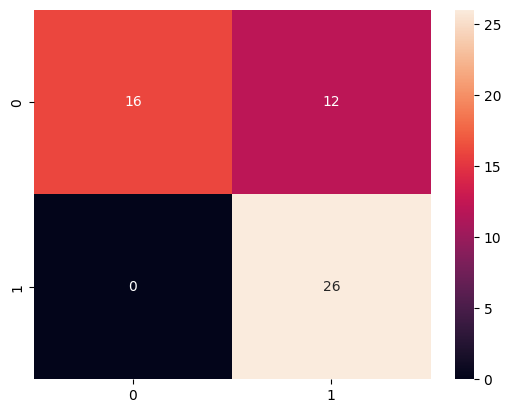

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(test_dataset.classes, predictions)
sns.heatmap(cm, annot=True)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_dataset.classes, predictions))

              precision    recall  f1-score   support

           0       1.00      0.57      0.73        28
           1       0.68      1.00      0.81        26

    accuracy                           0.78        54
   macro avg       0.84      0.79      0.77        54
weighted avg       0.85      0.78      0.77        54



## Fine tuning

### Implementing

In [ ]:
# 전통적인 CNN보다 결과가 좋지 않으므로 파인튜닝을 적용해 볼 것임.
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
for layer in base_model.layers:
    print(layer, layer.trainable)

<InputLayer name=input_layer_1, built=True> True
<ZeroPadding2D name=conv1_pad, built=True> True
<Conv2D name=conv1_conv, built=True> True
<BatchNormalization name=conv1_bn, built=True> True
<Activation name=conv1_relu, built=True> True
<ZeroPadding2D name=pool1_pad, built=True> True
<MaxPooling2D name=pool1_pool, built=True> True
<Conv2D name=conv2_block1_1_conv, built=True> True
<BatchNormalization name=conv2_block1_1_bn, built=True> True
<Activation name=conv2_block1_1_relu, built=True> True
<Conv2D name=conv2_block1_2_conv, built=True> True
<BatchNormalization name=conv2_block1_2_bn, built=True> True
<Activation name=conv2_block1_2_relu, built=True> True
<Conv2D name=conv2_block1_0_conv, built=True> True
<Conv2D name=conv2_block1_3_conv, built=True> True
<BatchNormalization name=conv2_block1_0_bn, built=True> True
<BatchNormalization name=conv2_block1_3_bn, built=True> True
<Add name=conv2_block1_add, built=True> True
<Activation name=conv2_block1_out, built=True> True
<Conv2D name

In [ ]:
len(base_model.layers)

175

In [ ]:
# 어느 층을 고정하고 어느 층의 고정을 해제할 지 결정해야 함.
fine_tuning_at = 140
# 140 전의 층들은 고정. 140번째 층부터 자유롭게 학습 가능(가중치 변경 가능).
# 중요한 것은 고정을 해제할 때 마지막 합성곱 층을 선택해야 함.
# 첫번째 합성곱 층은 일반적인 특징과 더 관련이 있기 때문.
# 숫자가 작을 수록 시간이 많이 걸림.

In [ ]:
for layer in base_model.layers[:fine_tuning_at]:
    layer.trainable = False

In [ ]:
network.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = network.fit(train_dataset, epochs=50)

Epoch 1/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 35s 443ms/step - accuracy: 0.5522 - loss: 6.5463
Epoch 2/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - accuracy: 0.4388 - loss: 1.0919
Epoch 3/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 137ms/step - accuracy: 0.5437 - loss: 0.7473
Epoch 4/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 102ms/step - accuracy: 0.6226 - loss: 0.6008
Epoch 5/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 106ms/step - accuracy: 0.6788 - loss: 0.5359
Epoch 6/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.7119 - loss: 0.5255
Epoch 7/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 104ms/step - accuracy: 0.6082 - loss: 0.6925
Epoch 8/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.7326 - loss: 0.4866
Epoch 9/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 103ms/step - accuracy: 0.7165 - loss: 0.5245
Epoch 10/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/step - accuracy: 0.8370 - loss: 0.4767
Epoch 11/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 149ms/step - accuracy: 0.7246 - loss: 0.5926
Epoch 12/50
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 104ms/st

### Evaluate

In [ ]:
predictions = network.predict(test_dataset)
predictions

54/54 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


array([[7.5604773e-01, 2.4395230e-01],
       [9.9929833e-01, 7.0169888e-04],
       [1.2256574e-03, 9.9877435e-01],
       [9.9992025e-01, 7.9723322e-05],
       [9.5248187e-01, 4.7518071e-02],
       [9.9590683e-01, 4.0931907e-03],
       [1.8406584e-03, 9.9815935e-01],
       [6.1841226e-01, 3.8158777e-01],
       [5.8593953e-01, 4.1406047e-01],
       [6.7219633e-01, 3.2780367e-01],
       [1.9201147e-05, 9.9998081e-01],
       [9.4523424e-01, 5.4765809e-02],
       [9.7943348e-01, 2.0566447e-02],
       [4.4058624e-01, 5.5941379e-01],
       [9.0238610e-03, 9.9097615e-01],
       [9.9718374e-01, 2.8162554e-03],
       [8.9068341e-01, 1.0931651e-01],
       [7.0533293e-01, 2.9466701e-01],
       [9.9256706e-01, 7.4328878e-03],
       [9.9481601e-01, 5.1839827e-03],
       [9.0997046e-01, 9.0029508e-02],
       [9.6628577e-01, 3.3714175e-02],
       [9.9766749e-01, 2.3324313e-03],
       [5.4375076e-01, 4.5624927e-01],
       [9.9990654e-01, 9.3507704e-05],
       [9.5474082e-01, 4.

In [ ]:
predictions = np.argmax(predictions, axis=1)
predictions

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
test_dataset.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_dataset.classes, predictions)
# 기존의 전이 학습 기법보다 성능이 좋음.
# 캐릭터 이미지는 이미지넷 데이터셋에 있는 현실 이미지와 유사하지 않음.
# 결과를 개선하기 위해 파인튜닝을 진행했으며, 에포크를 더 크게 해봐도 됨.

0.9074074074074074

## Saving and loading the model

In [ ]:
model_json = network.to_json()
with open('network.json', 'w') as json_file:
    json_file.write(model_json)

In [ ]:
from keras.models import save_model
network_saved = save_model(network, '/content/weights.hdf5')

In [ ]:
with open('network.json', 'r') as json_file:
    json_saved_model = json_file.read()
json_saved_model

'{"module": "keras.src.models.functional", "class_name": "Functional", "config": {"name": "functional", "trainable": true, "layers": [{"module": "keras.layers", "class_name": "InputLayer", "config": {"batch_shape": [null, 256, 256, 3], "dtype": "float32", "sparse": false, "name": "input_layer_1"}, "registered_name": null, "name": "input_layer_1", "inbound_nodes": []}, {"module": "keras.layers", "class_name": "ZeroPadding2D", "config": {"name": "conv1_pad", "trainable": false, "dtype": {"module": "keras", "class_name": "DTypePolicy", "config": {"name": "float32"}, "registered_name": null}, "padding": [[3, 3], [3, 3]], "data_format": "channels_last"}, "registered_name": null, "build_config": {"input_shape": [null, 256, 256, 3]}, "name": "conv1_pad", "inbound_nodes": [{"args": [{"class_name": "__keras_tensor__", "config": {"shape": [null, 256, 256, 3], "dtype": "float32", "keras_history": ["input_layer_1", 0, 0]}}], "kwargs": {}}]}, {"module": "keras.layers", "class_name": "Conv2D", "conf

In [ ]:
network_loaded = tf.keras.models.model_from_json(json_saved_model)
network_loaded.load_weights('weights.hdf5')
network_loaded.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
network_loaded.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 262, 262, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 128, 128, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 128, 128, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 128, 128, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 130, 130, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 64, 64, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 64, 64, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 64, 64, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 64, 64, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 64, 64, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 64, 64, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 64, 64, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 26,741,639 (102.01 MB)

 Trainable params: 18,131,975 (69.17 MB)

 Non-trainable params: 8,609,664 (32.84 MB)

## Classifying one single image

In [ ]:
image = cv2.imread('/content/homer_bart_2/test_set/homer/homer15.bmp')

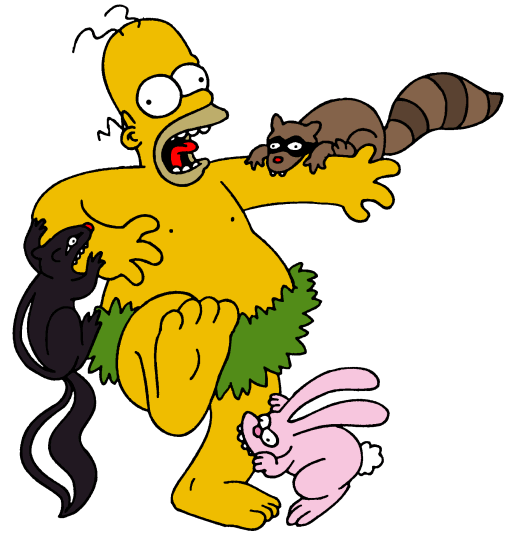

In [ ]:
cv2_imshow(image)

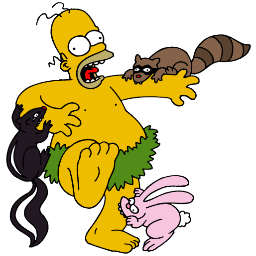

In [ ]:
image = cv2.resize(image, (256,256))
cv2_imshow(image)

In [ ]:
image,

(array([[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        ...,
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],
 
        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
  

In [ ]:
image = image / 255
image

array([[[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       ...,

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]],

       [[1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.],
        ...,
        [1., 1., 1.],
        [1., 1., 1.],
        [1., 1., 1.]]])

In [ ]:
image.shape

(256, 256, 3)

In [ ]:
image = image.reshape(-1, 256, 256, 3)
image.shape

(1, 256, 256, 3)

In [ ]:
result = network_loaded(image)
result

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[2.4381031e-06, 9.9999762e-01]], dtype=float32)>

In [ ]:
result = np.argmax(result)
result

1

In [ ]:
test_dataset.class_indices

{'bart': 0, 'homer': 1}

In [ ]:
if result == 0:
    print('Bart')
else:
    print('Homer')

Homer
